In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/root/specialised-SAEs/")
from datasets import load_dataset, Dataset
from transformer_lens import utils, HookedTransformer
import gc
import torch
from tqdm import tqdm
import pandas as pd
import plotly.express as px

from sae_lens.jacob.load_sae_from_hf import load_sae_from_hf
from sae_lens.config import DTYPE_MAP
from sae_lens.sae import SAE

torch.set_grad_enabled(False)

from mmlu_eval import get_mmlu_accuracy

In [3]:
# Set these variables
DTYPE = "bfloat16"
model_name = "gemma-2-2b-it"
model = HookedTransformer.from_pretrained_no_processing(model_name, device="cuda", dtype=DTYPE)

# # Set these HF file paths
# gsae = load_sae_from_hf("jacobcd52/gemma2-gsae", 
#                         "sae_weights.safetensors", 
#                         "cfg.json",
#                         device="cuda", dtype=DTYPE)

gsae = SAE.from_pretrained('gemma-scope-2b-pt-res',
                           'layer_7/width_65k/average_l0_31',
                           device="cuda", dtype=DTYPE)[0]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b-it into HookedTransformer


params.npz:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

load state dict dtype bfloat16
loaded sae from state dict, dtype torch.bfloat16


In [4]:
accs = {}
probs = {}

for subject in [
                "college_biology",
                "college_medicine",
                "high_school_macroeconomics",
                "high_school_microeconomics",
                "high_school_biology",
                "high_school_us_history",
                "high_school_european_history",
                "high_school_geography",
                "high_school_government_and_politics",
                "high_school_psychology",           
                "medical_genetics",
                "philosophy",
                ]:

    patched_acc, patched_correct_prob = get_mmlu_accuracy(
        model,
        sae_list = [gsae],
        subject = subject
    )

    clean_acc, clean_correct_prob = get_mmlu_accuracy(
        model,
        sae_list = None,
        subject = subject
    )

    print(subject)
    print(clean_acc, patched_acc)
    print(clean_correct_prob, patched_correct_prob)
    print()
    accs[subject] = (clean_acc, patched_acc)
    probs[subject] = (clean_correct_prob, patched_correct_prob)

139it [00:13, 10.08it/s]
139it [00:13, 10.14it/s]


college_biology
0.7050359712230215 0.5683453237410072
0.6924276065023569 0.49369758835209787



168it [00:21,  7.88it/s]
168it [00:20,  8.24it/s]


college_medicine
0.6190476190476191 0.5416666666666666
0.6045760203320415 0.4514602271485187



385it [00:42,  9.05it/s]
385it [00:40,  9.61it/s]


high_school_macroeconomics
0.6285714285714286 0.5194805194805194
0.6136158332939625 0.45859108022353673



233it [00:25,  9.09it/s]
233it [00:23,  9.79it/s]


high_school_microeconomics
0.6266094420600858 0.51931330472103
0.6200255549940242 0.45141103810554795



305it [00:29, 10.47it/s]
305it [00:28, 10.84it/s]


high_school_biology
0.7508196721311475 0.6622950819672131
0.7442769451846453 0.5598276601646279



199it [01:09,  2.86it/s]
199it [01:07,  2.96it/s]


high_school_us_history
0.7537688442211056 0.6582914572864321
0.7533705983061288 0.5981781232737042



160it [00:58,  2.75it/s]
160it [00:55,  2.87it/s]


high_school_european_history
0.7375 0.6375
0.7187162060415175 0.5732616457156837



193it [00:16, 11.53it/s]
193it [00:16, 11.74it/s]


high_school_geography
0.7875647668393783 0.6735751295336787
0.7813343153924167 0.5722744431578279



188it [00:21,  8.74it/s]
188it [00:21,  8.76it/s]


high_school_government_and_politics
0.8351063829787234 0.7287234042553191
0.8189816032512333 0.6135452006438232



540it [00:48, 11.06it/s]
540it [00:47, 11.29it/s]


high_school_psychology
0.8407407407407408 0.7018518518518518
0.8305814086288862 0.6485701503236433



95it [00:07, 12.25it/s]
95it [00:07, 12.85it/s]


medical_genetics
0.6842105263157895 0.5684210526315789
0.6683662566558556 0.5033909857493678



306it [00:26, 11.63it/s]
306it [00:24, 12.74it/s]

philosophy
0.6503267973856209 0.5261437908496732
0.6524923755437306 0.4805191501543638



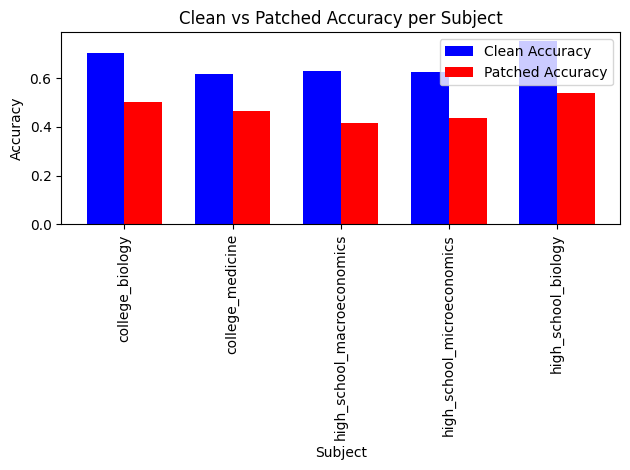

In [25]:
import matplotlib.pyplot as plt
import numpy as np

data = accs

# Unpack the data
subjects = list(data.keys())
clean_accuracies = [val[0] for val in data.values()]
patched_accuracies = [val[1] for val in data.values()]

# Bar width and positions
bar_width = 0.35
index = np.arange(len(subjects))

# Plotting the bars
plt.bar(index, clean_accuracies, bar_width, color='blue', label='Clean Accuracy')
plt.bar(index + bar_width, patched_accuracies, bar_width, color='red', label='Patched Accuracy')

# Adding labels and title
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.title('Clean vs Patched Accuracy per Subject')
plt.xticks(index + bar_width / 2, subjects, rotation=90)  # Rotate labels by 90 degrees
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

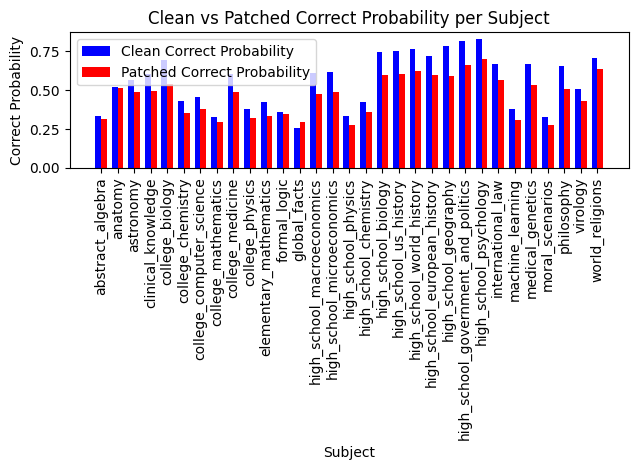

In [18]:
data = probs

# Unpack the data
subjects = list(data.keys())
clean_accuracies = [val[0] for val in data.values()]
patched_accuracies = [val[1] for val in data.values()]

# Bar width and positions
bar_width = 0.35
index = np.arange(len(subjects))

# Plotting the bars
plt.bar(index, clean_accuracies, bar_width, color='blue', label='Clean Correct Probability')
plt.bar(index + bar_width, patched_accuracies, bar_width, color='red', label='Patched Correct Probability')

# Adding labels and title
plt.xlabel('Subject')
plt.ylabel('Correct Probability')
plt.title('Clean vs Patched Correct Probability per Subject')
plt.xticks(index + bar_width / 2, subjects, rotation=90)  # Rotate labels by 90 degrees
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()